# Comparison of MLP and Bayes NN on Diabetest dataset

### Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import zhusuan as zs

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

tf.set_random_seed(123)
np.random.seed(321)

/home/glegeza/Programming/semestr2/bayesian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/glegeza/Programming/semestr2/bayesian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/glegeza/Programming/semestr2/bayesian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

### Load data

In [2]:
X_, y_ = load_diabetes(return_X_y=True)
train_X, test_X, train_y, test_y = train_test_split(X_, y_, test_size=.2, random_state=42)

n_train, x_dim = train_X.shape
n_test = test_X.shape[0]
y_dim = 1

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((353, 10), (353,), (89, 10), (89,))

### Standarize data

In [3]:
def standardize(data_train, data_test):
    """
    Standardize a dataset to have zero mean and unit standard deviation.

    :param data_train: 2-D Numpy array. Training data.
    :param data_test: 2-D Numpy array. Test data.

    :return: (train_set, test_set, mean, std), The standardized dataset and
        their mean and standard deviation before processing.
    """
    std = np.std(data_train, 0, keepdims=True)
    std[std == 0] = 1
    mean = np.mean(data_train, 0, keepdims=True)
    data_train_standardized = (data_train - mean) / std
    data_test_standardized = (data_test - mean) / std
    mean, std = np.squeeze(mean, 0), np.squeeze(std, 0)
    return data_train_standardized, data_test_standardized, mean, std

In [4]:
train_X_standard, test_X_standard, _, _ = standardize(train_X, test_X)
train_y_standard, test_y_standard, _, std_y_train = standardize(train_y, test_y)

### Defintion of parameters

In [5]:
n_hiddens = [64, 32]
layer_sizes = [x_dim] + n_hiddens + [y_dim]

epochs = 50
lr = 0.005
batch_size = 100 

### MLP model

In [6]:
mlp = Sequential()
mlp.add(Dense(layer_sizes[1], activation="relu", input_shape=(x_dim,)))
for out_dim in layer_sizes[2:-1]:
    mlp.add(Dense(out_dim, activation="relu"))
mlp.add(Dense(y_dim, activation="linear"))

optimizer = Adam(lr=lr)
mlp.compile(
    loss="mean_squared_error", optimizer=optimizer, metrics=["mean_squared_error"]
)
mlp.build()
mlp.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


In [7]:
training_results = mlp.fit(
                            x=train_X_standard,
                            y=train_y_standard,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(test_X_standard, test_y_standard),
                        )

Train on 353 samples, validate on 89 samples
Instructions for updating:
Use tf.cast instead.


2023-12-21 23:36:48.463628: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-12-21 23:36:48.486306: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1800000000 Hz
2023-12-21 23:36:48.486723: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55ecdc7d8b30 executing computations on platform Host. Devices:
2023-12-21 23:36:48.486750: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Epoch 1/50
353/353 [==============================] - 0s 484us/sample - loss: 0.8672 - mean_squared_error: 0.8672 - val_loss: 0.5600 - val_mean_squared_error: 0.5600
Epoch 2/50
353/353 [==============================] - 0s 19us/sample - loss: 0.5623 - mean_squared_error: 0.5623 - val_loss: 0.4849 - val_mean_squared_error: 0.4849
Epoch 3/50
353/353 [==============================] - 0s 27us/sample - loss: 0.4883 - mean_squared_error: 0.4883 - val_loss: 0.4610 - val_mean_squared_error: 0.4610
Epoch 4/50
353/353 [==============================] - 0s 26us/sample - loss: 0.4728 - mean_squared_error: 0.4728 - val_loss: 0.4472 - val_mean_squared_error: 0.4472
Epoch 5/50
353/353 [==============================] - 0s 26us/sample - loss: 0.4390 - mean_squared_error: 0.4390 - val_loss: 0.4242 - val_mean_squared_error: 0.4242
Epoch 6/50
353/353 [==============================] - 0s 25us/sample - loss: 0.4195 - mean_squared_error: 0.4195 - val_loss: 0.4231 - val_mean_squared_error: 0.4231
Epoch 7/5

In [8]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    # plt.xlim([0, 20])
    # plt.ylim(ylim)
    # Tailor x-axis tick marks
    # ax.xaxis.set_major_locator(MultipleLocator(5))
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    # ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

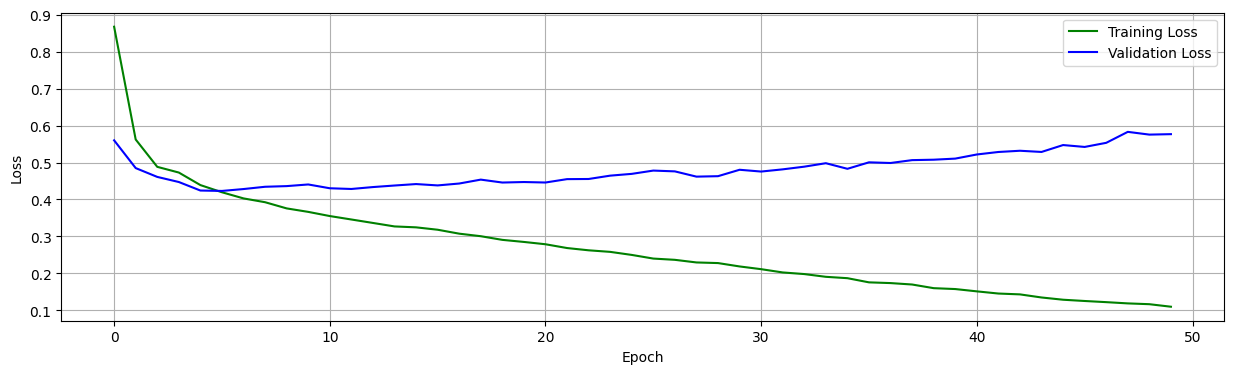

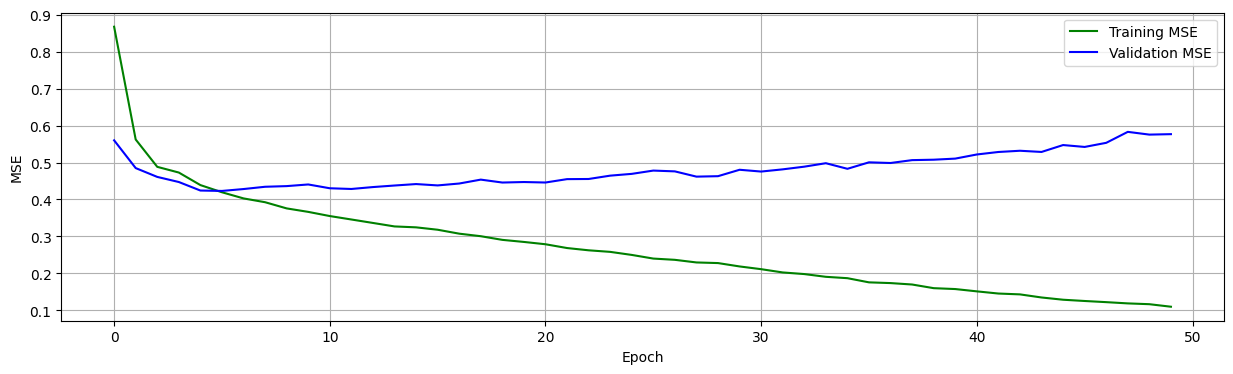

In [9]:
train_loss = training_results.history["loss"]
valid_loss = training_results.history["val_loss"]
train_acc  = training_results.history["mean_squared_error"]
valid_acc  = training_results.history["val_mean_squared_error"]

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ], 
            ylabel="MSE",
            metric_name=["Training MSE", "Validation MSE"],
            color=["g", "b"])

### Bayes NN model

In [10]:
lr=0.05

In [11]:
@zs.meta_bayesian_net(scope="bnn", reuse_variables=True)
def build_bnn(x, layer_sizes, n_particles):
    bn = zs.BayesianNet()
    h = tf.tile(x[None, ...], [n_particles, 1, 1])
    for i, (n_in, n_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        w = bn.normal("w" + str(i), tf.zeros([n_out, n_in + 1]), std=1.,
                      group_ndims=2, n_samples=n_particles)
        h = tf.concat([h, tf.ones(tf.shape(h)[:-1])[..., None]], -1)
        h = tf.einsum("imk,ijk->ijm", w, h) / tf.sqrt(
            tf.cast(tf.shape(h)[2], tf.float32))
        if i < len(layer_sizes) - 2:
            h = tf.nn.relu(h)

    y_mean = bn.deterministic("y_mean", tf.squeeze(h, 2))
    y_logstd = tf.get_variable("y_logstd", shape=[],
                               initializer=tf.constant_initializer(0.))
    bn.normal("y", y_mean, logstd=y_logstd)
    return bn

In [12]:
@zs.reuse_variables(scope="variational")
def build_mean_field_variational(layer_sizes, n_particles):
    bn = zs.BayesianNet()
    for i, (n_in, n_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        w_mean = tf.get_variable(
            "w_mean_" + str(i), shape=[n_out, n_in + 1],
            initializer=tf.constant_initializer(0.))
        w_logstd = tf.get_variable(
            "w_logstd_" + str(i), shape=[n_out, n_in + 1],
            initializer=tf.constant_initializer(0.))
        bn.normal("w" + str(i), w_mean, logstd=w_logstd,
                  n_samples=n_particles, group_ndims=2)
    return bn

In [13]:
n_particles = tf.placeholder(tf.int32, shape=[], name="n_particles")
x = tf.placeholder(tf.float32, shape=[None, x_dim])
y = tf.placeholder(tf.float32, shape=[None])
w_names = ["w" + str(i) for i in range(len(layer_sizes) - 1)]

In [14]:
model = build_bnn(x, layer_sizes, n_particles)
variational = build_mean_field_variational(layer_sizes, n_particles)

def log_joint(bn):
    log_pws = bn.cond_log_prob(w_names)
    log_py_xw = bn.cond_log_prob('y')
    return tf.add_n(log_pws) + tf.reduce_mean(log_py_xw, 1) * n_train

model.log_joint = log_joint

lower_bound = zs.variational.elbo(
    model, {'y': y}, variational=variational, axis=0)
cost = lower_bound.sgvb()

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
infer_op = optimizer.minimize(cost)

In [15]:
y_mean = lower_bound.bn["y_mean"]
y_pred = tf.reduce_mean(y_mean, 0)
y_true = y
mse = tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))
log_py_xw = lower_bound.bn.cond_log_prob("y")
log_likelihood = tf.reduce_mean(zs.log_mean_exp(log_py_xw, 0)) - tf.log(tf.cast(std_y_train, tf.float32))

In [16]:
lb_samples = 10
ll_samples = 5000
epochs = 50
batch_size = 10
iters = (n_train-1) // batch_size + 1
test_iters = (n_test-1) // batch_size + 1
test_freq = 1

In [17]:
# Run the inference
train_mses = []
test_mses= []

train_lbs = []
test_lbs = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(1, epochs + 1):
        perm = np.random.permutation(train_X_standard.shape[0])
        train_X_standard = train_X_standard[perm, :]
        train_y_standard = train_y_standard[perm]
        lbs = []
        for t in range(iters):
            x_batch = train_X_standard[t * batch_size:(t + 1) * batch_size]
            y_batch = train_y_standard[t * batch_size:(t + 1) * batch_size]
            if len(x_batch) == 0:
                continue
            _, lb = sess.run(
                [infer_op, lower_bound],
                feed_dict={n_particles: lb_samples,
                           x: x_batch, y: y_batch})
            lbs.append(lb)
        train_lb = np.mean(lbs)
        train_lbs.append(train_lb)
        print('Epoch {}: Lower bound = {};'.format(epoch, train_lb))

        if epoch % test_freq == 0:
            train_mse, train_ll = sess.run(
                [mse, log_likelihood],
                feed_dict={n_particles: ll_samples,
                            x: train_X_standard, y: train_y_standard})
            train_mses.append(train_mse)
            # print('>> TRAIN')
            # print('>> Train mse = {}, log_likelihood = {}'.format(train_mse, train_ll))
            # for t in range(iters):
            #     x_batch = test_X_standard[t * batch_size:(t + 1) * batch_size]
            #     y_batch = test_y_standard[t * batch_size:(t + 1) * batch_size]
            #     if len(x_batch) == 0:
            #         continue
            test_mse, test_ll = sess.run(
                [mse, log_likelihood],
                feed_dict={n_particles: ll_samples,
                            x: test_X_standard, y: test_y_standard})
            test_lb = sess.run(
                [lower_bound],
                feed_dict={n_particles: lb_samples,
                           x: test_X_standard, y: test_y_standard})
            test_lbs.append(test_lb)
            test_mses.append(test_mse)
            
            # print('>> TEST')
            # print('>> Test mse = {}, log_likelihood = {}'.format(test_mse, test_ll))

Epoch 1: Lower bound = -579.9129028320312;


2023-12-21 23:36:52.676644: W tensorflow/core/framework/allocator.cc:124] Allocation of 451840000 exceeds 10% of system memory.
2023-12-21 23:36:52.746588: W tensorflow/core/framework/allocator.cc:124] Allocation of 451840000 exceeds 10% of system memory.
2023-12-21 23:36:52.999754: W tensorflow/core/framework/allocator.cc:124] Allocation of 458900000 exceeds 10% of system memory.
2023-12-21 23:36:53.109077: W tensorflow/core/framework/allocator.cc:124] Allocation of 458900000 exceeds 10% of system memory.


Epoch 2: Lower bound = -553.5249633789062;


2023-12-21 23:36:54.475797: W tensorflow/core/framework/allocator.cc:124] Allocation of 451840000 exceeds 10% of system memory.


Epoch 3: Lower bound = -554.1260375976562;
Epoch 4: Lower bound = -555.6183471679688;
Epoch 5: Lower bound = -558.3344116210938;
Epoch 6: Lower bound = -558.4535522460938;
Epoch 7: Lower bound = -557.000732421875;
Epoch 8: Lower bound = -566.7566528320312;
Epoch 9: Lower bound = -559.7567138671875;
Epoch 10: Lower bound = -555.7669067382812;
Epoch 11: Lower bound = -563.372314453125;
Epoch 12: Lower bound = -554.1651611328125;
Epoch 13: Lower bound = -571.3385620117188;
Epoch 14: Lower bound = -555.3511962890625;
Epoch 15: Lower bound = -554.6021118164062;
Epoch 16: Lower bound = -561.8569946289062;
Epoch 17: Lower bound = -560.158447265625;
Epoch 18: Lower bound = -573.233154296875;
Epoch 19: Lower bound = -568.174072265625;
Epoch 20: Lower bound = -569.674072265625;
Epoch 21: Lower bound = -553.30859375;
Epoch 22: Lower bound = -561.5789794921875;
Epoch 23: Lower bound = -554.1494140625;
Epoch 24: Lower bound = -549.988525390625;
Epoch 25: Lower bound = -550.0753173828125;
Epoch 26: 

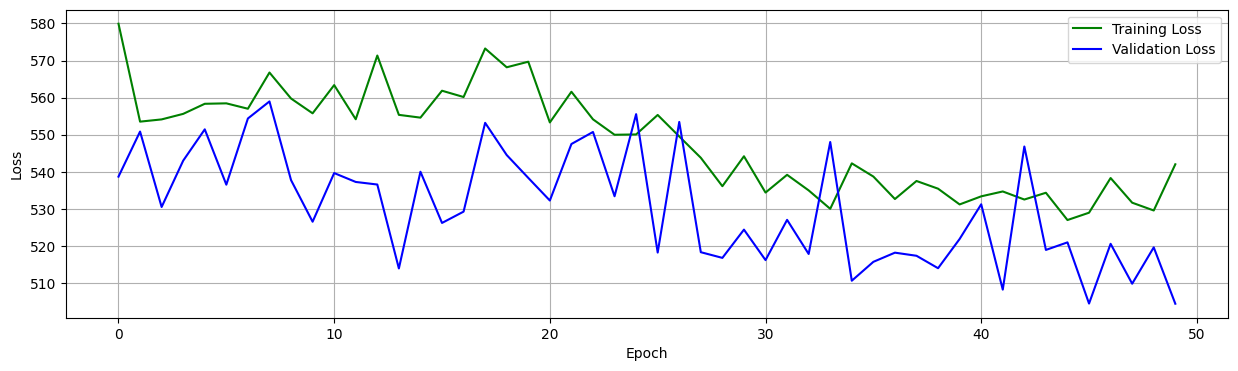

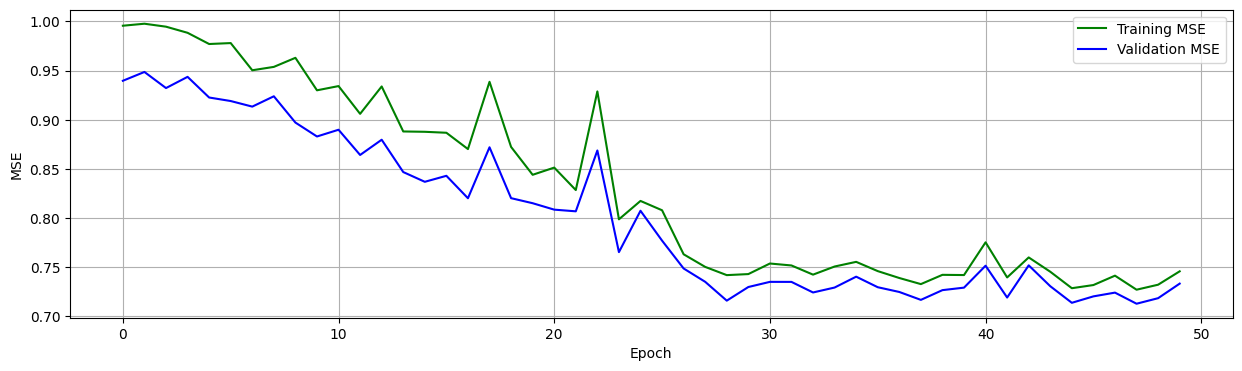

In [18]:
plot_results([ np.abs(train_lbs), np.abs(test_lbs) ],
            ylabel="Loss",
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"])

plot_results([ train_mses, test_mses ],
            ylabel="MSE",
            metric_name=["Training MSE", "Validation MSE"],
            color=["g", "b"])